# Tutorial: Using DADApy to analyse a molecular dynamics trajectory of a small peptide

In this notebook we use DADApy to analyse a dataset consisting of an enhanced molecular dynamics trajectory of a small protein with a beta-hairpin structure (CLN025).
The analyses carried out here are analogous to those described in the article *DADApy: Distance-based Analysis of DAta-manifolds in Python*, available at https://arxiv.org/abs/2205.03373.

In [1]:
# import the necessary modules
from dadapy import Data
from dadapy import plot as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("notebook")

from urllib.request import urlretrieve

data_url_dihedrals = "https://figshare.com/ndownloader/files/36359700"
path_dihedrals = "./cln025traj_dihedrals_decimated_equilibrated.npy"
data_url_distances = "https://figshare.com/ndownloader/files/36359697"
path_distances = "./cln025traj_distances_decimated_equilibrated.npy"

## Analysing the trajectory using selected dihedral angles

In this first part of tha analysis we use a compact data representation given by 15 dihedral angles selected as the most informative out of all 32 dihedral angles of the protein.

In [2]:
# download dihedral representation data from Figshare
urlretrieve(data_url_dihedrals, path_dihedrals)

('./cln025traj_dihedrals_decimated_equilibrated.npy',
 <http.client.HTTPMessage at 0x7f91b1d12880>)

In [3]:
all_dihedrals = np.load(path_dihedrals)
# dihedral names in order:
# phi1 phi2 phi3 phi4 phi5 phi6 phi7 phi8 phi9
# psi1 psi2 psi3 psi4 psi5 psi6 psi7 psi8 psi9
# chi1_1 chi1_2 chi1_3 chi1_5 chi1_6 chi1_8 chi1_9 chi1_10
# chi2_1 chi2_2 chi2_3 chi2_5 chi2_9 chi2_10

In [4]:
# we then select a subset of 15 dihedrals identified as the most informative
# using the information imbalance greedy optimisation of (Glielmo et al., PNAS Nexus, 2022)
# the final dataset is described by only 15 features
coords_from_information_imbalance = [
    1,
    4,
    5,
    7,
    10,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    24,
    25,
]
selected_dihedrals = all_dihedrals[:, coords_from_information_imbalance]

print(selected_dihedrals.shape)

(3758, 15)


### Using DADApy

In [5]:
# initialise a Data object
d_dihedrals = Data(selected_dihedrals + np.pi, verbose=False)
# compute distances by setting the correct period
d_dihedrals.compute_distances(
    maxk=min(selected_dihedrals.shape[0] - 1, 10000), period=2.0 * np.pi
)
# estimate the intrinsic dimension
d_dihedrals.compute_id_2NN()

(7.626068770614549, 0.0, 1.5196095123677547)

In [6]:
# ID scaling analysig using two different methods
ids_2nn, errs_2nn, scales_2nn = d_dihedrals.return_id_scaling_2NN()
ids_gride, errs_gride, scales_gride = d_dihedrals.return_id_scaling_gride(
    range_max=1024
)

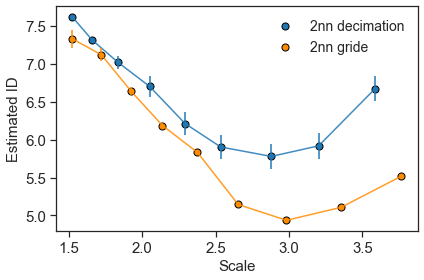

In [7]:
col = "darkorange"
plt.plot(scales_2nn, ids_2nn, alpha=0.85)
plt.errorbar(scales_2nn, ids_2nn, errs_2nn, fmt="None")
plt.scatter(scales_2nn, ids_2nn, edgecolors="k", s=50, label="2nn decimation")
plt.plot(scales_gride, ids_gride, alpha=0.85, color=col)
plt.errorbar(scales_gride, ids_gride, errs_gride, fmt="None", color=col)
plt.scatter(scales_gride, ids_gride, edgecolors="k", color=col, s=50, label="2nn gride")
plt.xlabel(r"Scale", size=15)
plt.ylabel("Estimated ID", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()

In [8]:
# estimate density via PAk
d_dihedrals.set_id(7.0)
d_dihedrals.compute_density_PAk()

(array([-13.4 , -17.32,  -7.46, ..., -10.54,  -6.94, -11.01]),
 array([0.42, 0.42, 0.54, ..., 0.4 , 0.54, 0.44]))

In [9]:
# cluster data via Advanced Density Peak
d_dihedrals.compute_clustering_ADP(Z=4.5, halo=False)
n_clusters = len(d_dihedrals.cluster_centers)
print(n_clusters)

3758
3


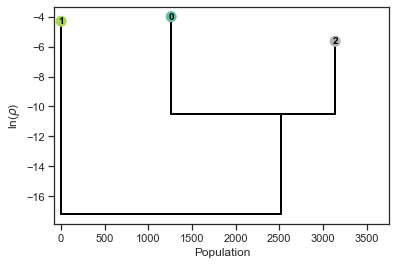

In [10]:
pl.get_dendrogram(d_dihedrals, cmap="Set2", logscale=False)

In [11]:
# Cluster populations
populations = [len(el) for r_, el in enumerate(d_dihedrals.cluster_indices)]
populations

[2516, 3, 1239]

In [12]:
# Cluster centers. In the original trajecotory these frames are given by (center + 400) * 10
d_dihedrals.cluster_centers

[1675, 2306, 3349]

## Analysing the trajectory using all heavy atom distances

In this second part of tha analysis we use an alternative data representation consisting of the 4278 distances between the heavy atoms of the protein.

In [13]:
# download distance representation data from Figshare, this can take 1-2 minutes
urlretrieve(data_url_distances, path_distances)

('./cln025traj_distances_decimated_equilibrated.npy',
 <http.client.HTTPMessage at 0x7f919ada8ca0>)

In [14]:
heavy_atom_distances = np.load(path_distances)

In [15]:
print(heavy_atom_distances.shape)

(3758, 4278)


### Using DADApy

In [16]:
d_distances = Data(heavy_atom_distances, verbose=False)
d_distances.compute_distances(maxk=min(heavy_atom_distances.shape[0] - 1, 10000))
d_distances.compute_id_2NN()

(11.187504094865009, 0.0, 6.887884809073795)

In [17]:
# ID scaling analysig using two different methods
ids_2nn, errs_2nn, scales_2nn = d_distances.return_id_scaling_2NN()
ids_gride, errs_gride, scales_gride = d_distances.return_id_scaling_gride(
    range_max=1024
)

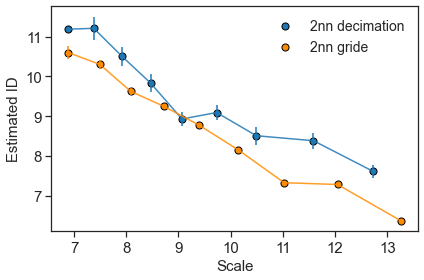

In [18]:
col = "darkorange"
plt.plot(scales_2nn, ids_2nn, alpha=0.85)
plt.errorbar(scales_2nn, ids_2nn, errs_2nn, fmt="None")
plt.scatter(scales_2nn, ids_2nn, edgecolors="k", s=50, label="2nn decimation")
plt.plot(scales_gride, ids_gride, alpha=0.85, color=col)
plt.errorbar(scales_gride, ids_gride, errs_gride, fmt="None", color=col)
plt.scatter(scales_gride, ids_gride, edgecolors="k", color=col, s=50, label="2nn gride")
plt.xlabel(r"Scale", size=15)
plt.ylabel("Estimated ID", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()

In [19]:
# estimate density via PAk
d_distances.set_id(9.0)
d_distances.compute_density_PAk()
# cluster data via Advanced Density Peak
d_distances.compute_clustering_ADP(Z=3.5, halo=False)
n_clusters = len(d_dihedrals.cluster_centers)
print(n_clusters)

3758
3


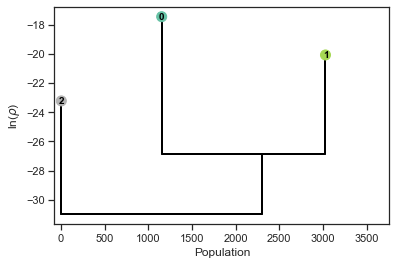

In [20]:
pl.get_dendrogram(d_distances, cmap="Set2", logscale=False)

In [21]:
# Cluster populations
populations = [len(el) for r_, el in enumerate(d_distances.cluster_indices)]
populations

[2291, 1460, 7]

In [22]:
# Cluster centers: In original trajecotory: (center + 400) * 10
d_distances.cluster_centers

[506, 1415, 3333]

## Check equivalence of the two data descriptions

Notably the dendrograms obtained with the two alternative data descriptions are very similar. 

They both consist of a very small cluster (depicted on the left of the dendrograms) and two large clusters (on the right).

The specific numbers defining the clusters are irrelevant, and exploiting this invariance we can transform the second cluster assignment to match the the first by exchanging the 1s with the 2s.

In [23]:
# number of elements in common before permutation
sum(d_distances.cluster_assignment == d_dihedrals.cluster_assignment) / d_dihedrals.N

0.5851516764236296

In [24]:
# permutation of cluster assignment: 2 -> 1 and 1 -> 2
distances_cluster_assignments_2 = np.copy(d_distances.cluster_assignment)

ones = np.where(d_distances.cluster_assignment == 1)
twos = np.where(d_distances.cluster_assignment == 2)

distances_cluster_assignments_2[ones] = 2
distances_cluster_assignments_2[twos] = 1

In [25]:
# number of elements in common after permutation
sum(distances_cluster_assignments_2 == d_dihedrals.cluster_assignment) / d_dihedrals.N

0.8879723257051623

Remarkably, the 4278-dimensional representation based on distances and the 15-dimensional representation based on dihedrals provide very similar results. Nearly 90% of the data falls under the same cluster assignment independently of the data representation!